In [5]:
import duckdb as db
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
def sql(query, database = "../data/database.duckdb"):
    con = db.connect(database)
    res = con.execute(query).df()
    con.close()
    return res

In [7]:
df = pd.DataFrame(sql(
    """  
    SELECT * 
    FROM name_basics
    """
))

In [8]:
df_tmdb = pd.DataFrame(sql(
    """  
    SELECT * 
    FROM tmdb
    """
))

In [9]:
#Isolement des acteurs/actrices
df_act = df[df['primaryProfession'].str.contains("director")]
df_act

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0050976,tt0083922"
7,nm0000008,Marlon Brando,1924,2004,"actor,director,writer","tt0078788,tt0068646,tt0047296,tt0044081"
8,nm0000009,Richard Burton,1925,1984,"actor,producer,director","tt0061184,tt0087803,tt0059749,tt0057877"
9,nm0000010,James Cagney,1899,1986,"actor,director,producer","tt0029870,tt0031867,tt0042041,tt0034236"
17,nm0000018,Kirk Douglas,1916,2020,"actor,producer,director","tt0043338,tt0080736,tt0054331,tt0049456"
...,...,...,...,...,...,...
14435880,nm9993679,Art Jones,\N,\N,director,tt8744074
14435895,nm9993694,Chinmay Mishra,\N,\N,"actor,director,producer","tt18361688,tt18687502,tt8737752,tt9083282"
14435896,nm9993696,Ibrahim-Aloduley,\N,\N,"director,editor",tt8744160
14435908,nm9993708,Eli Bevins,\N,\N,"producer,director,writer","tt36103776,tt11702702,tt14508814,tt36042179"


In [10]:
#Transofrmation de knownForTitles en liste
df_act['knownForTitles'] = df_act['knownForTitles'].apply(lambda x : x.split(","))
#explode
df_act_expl = df_act.explode("knownForTitles")
df_act_expl

/var/folders/w7/mwhn41wd4133mpd3qmk0b4lh0000gn/T/ipykernel_30479/3417930562.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_act['knownForTitles'] = df_act['knownForTitles'].apply(lambda x : x.split(","))


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor",tt0050986
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor",tt0069467
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor",tt0050976
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor",tt0083922
7,nm0000008,Marlon Brando,1924,2004,"actor,director,writer",tt0078788
...,...,...,...,...,...,...
14435908,nm9993708,Eli Bevins,\N,\N,"producer,director,writer",tt36042179
14435909,nm9993709,Lu Bevins,\N,\N,"producer,writer,director",tt17717854
14435909,nm9993709,Lu Bevins,\N,\N,"producer,writer,director",tt11772904
14435909,nm9993709,Lu Bevins,\N,\N,"producer,writer,director",tt11772812


In [11]:
#Création de la vue pour joindre Acteur/trics, films, année de sortie du film

sql("""
    CREATE OR REPLACE VIEW act_dec AS (SELECT primaryName
    , knownForTitles
    , original_title
    , YEAR(release_date) AS release_year
    FROM df_act_expl 
    JOIN tmdb ON df_act_expl.knownForTitles = tmdb.imdb_id
    ORDER BY primaryName);

    SELECT * from act_dec ORDER BY release_year ASC
    """
)

,primaryName,knownForTitles,original_title,release_year
0,P.J.C. Janssen,tt3155794,Passage de Venus,1874
1,Émile Reynaud,tt16763740,Le Jeu de Corde,1878
2,Étienne-Jules Marey,tt8588366,L'Homme Machine,1885
3,Louis Aimé Augustin Le Prince,tt2075247,Man Walking Around a Corner,1887
4,Louis Aimé Augustin Le Prince,tt0343112,Traffic Crossing Leeds Bridge,1888
...,...,...,...,...
745156,Jim Kallifatidis,tt20258920,Tin Soldier,<NA>
745157,Jim Lenz,tt11967240,A Fargo Christmas Story,<NA>
745158,Jim McSherry,tt1366983,La vérite du ciel,<NA>
745159,Jim Meyers,tt0382903,Phases of Death - Phase One: Through the Coron...,<NA>


In [12]:
#cCréation de la vue pour ajouter l'intervalle d'années

sql("""
        CREATE OR REPLACE VIEW act_dec_dec AS (SELECT *,
        CASE 
            WHEN release_year BETWEEN 1890 AND 1899 THEN '1890s'
            WHEN release_year BETWEEN 1900 AND 1909 THEN '1900s'
            WHEN release_year BETWEEN 1910 AND 1919 THEN '1910s'
            WHEN release_year BETWEEN 1920 AND 1929 THEN '1920s'
            WHEN release_year BETWEEN 1930 AND 1939 THEN '1930s'
            WHEN release_year BETWEEN 1940 AND 1949 THEN '1940s'
            WHEN release_year BETWEEN 1950 AND 1959 THEN '1950s'
            WHEN release_year BETWEEN 1960 AND 1969 THEN '1960s'
            WHEN release_year BETWEEN 1970 AND 1979 THEN '1970s'
            WHEN release_year BETWEEN 1980 AND 1989 THEN '1980s'
            WHEN release_year BETWEEN 1990 AND 1999 THEN '1990s'
            WHEN release_year BETWEEN 2000 AND 2009 THEN '2000s'
            WHEN release_year BETWEEN 2010 AND 2019 THEN '2010s'
            WHEN release_year BETWEEN 2020 AND 2025 THEN '2020s'
        END AS decade
        FROM act_dec ORDER BY decade);
        """
    )

df_root = sql("""SELECT * from act_dec_dec""")
df_root

,primaryName,knownForTitles,original_title,release_year,decade
0,Piotr Lebiedzinski,tt8094688,Krakowiak,1893,1890s
1,Robert W. Paul,tt0000170,The Twins' Tea Party,1896,1890s
2,Claire Lissalde,tt0000003,Pauvre Pierrot,1892,1890s
3,Claude Ferdinand Von Bernard,tt0350855,Duel au pistolet,1896,1890s
4,Claude Ferdinand Von Bernard,tt0424832,Baignade de chevaux,1896,1890s
...,...,...,...,...,...
745156,Chinmay Samnani,tt15375086,A Passenger in Love,<NA>,None
745157,Chinni Krishna,tt15433956,హను-మాన్,<NA>,None
745158,Chioma Thompson,tt22004344,The Snack Shack,<NA>,None
745159,Chiquita Mitchell,tt17490712,Mortal Kombat 2,<NA>,None


<Axes: xlabel='decade', ylabel='count'>

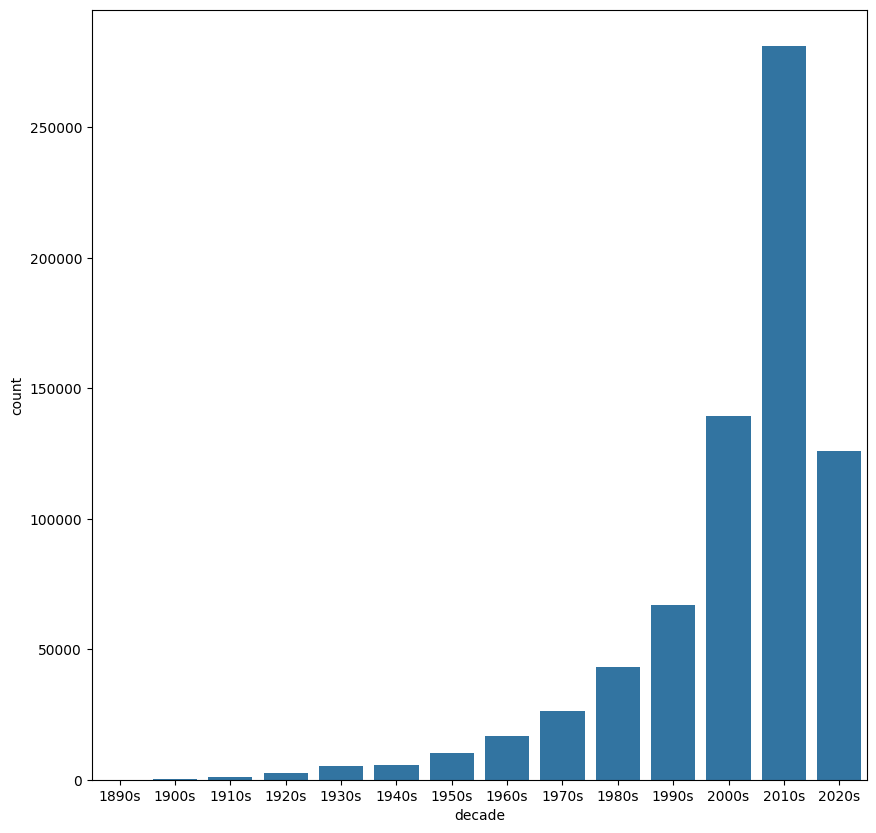

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sns.countplot(data=df_root, x='decade')

In [14]:
df_nbfilm_act = sql(""" 
    SELECT COUNT(knownForTitles) AS nb_films, 
    primaryName,
    decade
    FROM act_dec_dec
    GROUP BY decade, primaryName
    ORDER BY decade, nb_films DESC
    """
)
df_nbfilm_act

,nb_films,primaryName,decade
0,4,William Heise,1890s
1,4,Alexandre Promio,1890s
2,3,Louis Lumière,1890s
3,3,Charles Moisson,1890s
4,3,Emil Skladanowsky,1890s
...,...,...,...
531672,1,Tristan Ashwal,None
531673,1,Troy Dignon,None
531674,1,Tucker Ewing,None
531675,1,Tuna Ertutar,None


In [15]:
df_main = sql("""
    SELECT 
            primaryName,
            MAX(nb_films) AS nb_film_max,
            decade
            FROM df_nbfilm_act
            GROUP BY decade, primaryName
            ORDER BY decade, nb_film_max DESC
    """
)
df_main

,primaryName,nb_film_max,decade
0,Alexandre Promio,4,1890s
1,William Heise,4,1890s
2,Emil Skladanowsky,3,1890s
3,Louis Lumière,3,1890s
4,Max Skladanowsky,3,1890s
...,...,...,...
531672,Tucker Ewing,1,None
531673,Tuna Ertutar,1,None
531674,Tuomo Rysti,1,None
531675,Andjela Stanimirovic,1,None


In [16]:
main_bis = sql("""
    SELECT *,
    MAX(nb_film_max) OVER(PARTITION BY decade) MAXFILM
    from df_main
    ORDER BY decade, nb_film_max DESC
    """
)
main_bis

,primaryName,nb_film_max,decade,MAXFILM
0,Alexandre Promio,4,1890s,4
1,William Heise,4,1890s,4
2,Louis Lumière,3,1890s,4
3,Max Skladanowsky,3,1890s,4
4,Charles Moisson,3,1890s,4
...,...,...,...,...
531672,Jamie Suk,1,None,5
531673,Manuel Alejandro Ruiz,1,None,5
531674,Pam Mackinnon,1,None,5
531675,Paige Touzet,1,None,5


Text(0.5, 1.0, 'Nombre de film max par act')

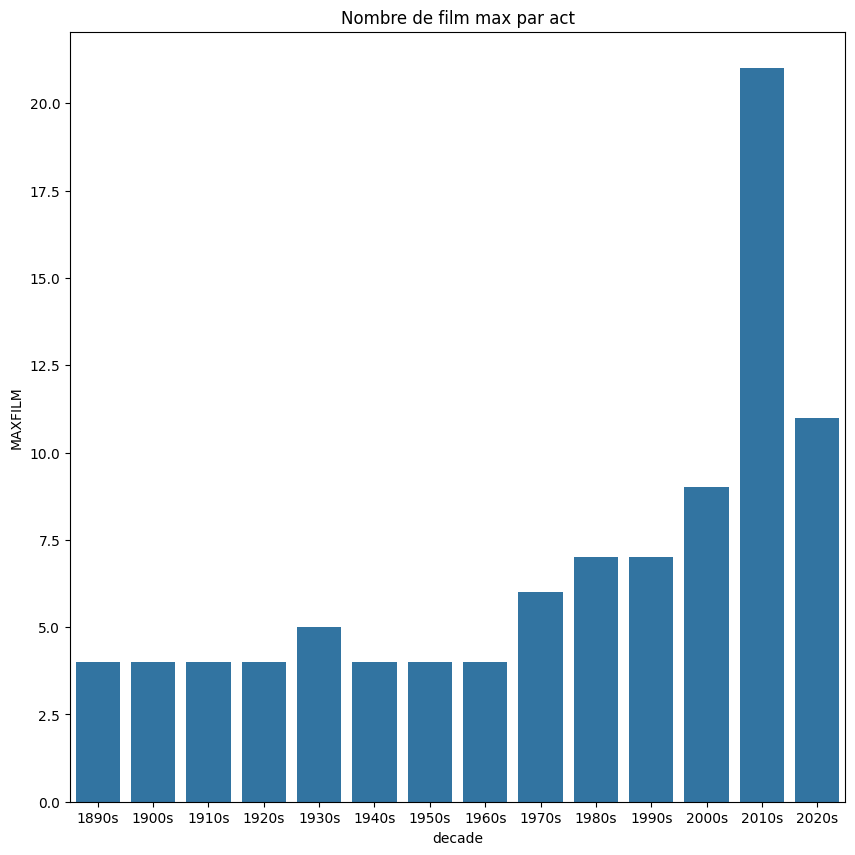

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(data=main_bis, x='decade', y='MAXFILM')
plt.title("Nombre de film max par dir")

In [18]:
df_max_film_act = sql("""SELECT primaryName, nb_film_max, decade FROM main_bis WHERE nb_film_max == MAXFILM""" )
df_max_film_act

,primaryName,nb_film_max,decade
0,Alexandre Promio,4,1890s
1,William Heise,4,1890s
2,Manuel,4,1900s
3,Ole Olsen,4,1910s
4,D.W. Griffith,4,1910s
...,...,...,...
433,David Jones,7,1990s
434,Matt Miller,9,2000s
435,Gurpreet Singh,21,2010s
436,Harpreet Singh,11,2020s


In [ ]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

fig = px.bar(df_max_film_act, x='nb_film_max' ,y= 'primaryName', animation_frame='decade')

fig.update_layout(
    xaxis_range=[0, df_nbfilm_act['nb_films'].max() + 2],
    yaxis_range= [0,20],
    xaxis_title="Nom",
    yaxis_title="Nombre de films",
    showlegend=False
)
fig.show()

In [92]:
df_ranked = sql("""
    SELECT *, RANK() OVER(PARTITION BY decade ORDER BY nb_film_max DESC) AS RANK from main_bis ORDER BY decade, RANK
    """)

df_ranked[df_ranked['decade'] == "1900s"]

,primaryName,nb_film_max,decade,MAXFILM,RANK
59,Manuel,4,1900s,4,1
60,A.E. Weed,3,1900s,4,2
61,Johann Schwarzer,3,1900s,4,2
62,Wallace McCutcheon,3,1900s,4,2
63,Félix Mesguich,3,1900s,4,2
...,...,...,...,...,...
156,Millard Mercury,1,1900s,4,29
157,Vladimir Siversen,1,1900s,4,29
158,Robert W. Paul,1,1900s,4,29
159,Joseph-Louis Mundwiller,1,1900s,4,29


In [102]:
decade_list = list(df_ranked['decade'].unique())
df = pd.DataFrame(columns=['primaryName','nb_film_max', 'MAXFILM', 'decade', 'RANK' ])

for dec in decade_list :
    print(dec)
    nb_dir = 0
    for i in df_ranked[df_ranked['decade'] == dec]:
        while nb_dir != 5 : 
            print(nb_dir)
            print((df_ranked[df_ranked['decade']== dec].iloc[i]))
            nb_dir += 1

1890s
0


TypeError: Cannot index by location index with a non-integer key

In [103]:
df = pd.DataFrame(columns=['primaryName', 'nb_film_max', 'MAXFILM', 'decade', 'RANK'])

for dec in df_ranked['decade'].unique():
    top5 = df_ranked[df_ranked['decade'] == dec].head(5)
    df = pd.concat([df, top5], ignore_index=True)

In [ ]:
df

,primaryName,nb_film_max,MAXFILM,decade,RANK
0,Alexandre Promio,4,4,1890s,1
1,William Heise,4,4,1890s,1
2,Louis Lumière,3,4,1890s,3
3,Max Skladanowsky,3,4,1890s,3
4,Charles Moisson,3,4,1890s,3
...,...,...,...,...,...
65,Harpreet Singh,11,11,2020s,1
66,Gurpreet Singh,10,11,2020s,2
67,Manpreet Singh,10,11,2020s,2
68,Gurwinder Singh,10,11,2020s,2


In [117]:
fig = px.bar(df, y='nb_film_max' ,x= 'primaryName', animation_frame='decade')

fig.update_layout(
    xaxis_range=[0,4],
    yaxis_range= [0, df['nb_film_max'].max() + 2],
    xaxis_title="Nom",
    yaxis_title="Nombre de films",
    showlegend=False
)
fig.show()

In [29]:
df_max_film_act['decade'].nunique()

14